# Importing liberies

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



import os
import cv2
import torch

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

%matplotlib inline


#ignoring warning 
import warnings
warnings.filterwarnings('ignore')



data_dir = "/kaggle/input/yawn-eye-dataset-new/dataset_new"

# Exploring dataset

In [5]:
print(os.listdir(data_dir))

train_classes = os.listdir(data_dir + "/train")
print(train_classes)

test_classes = os.listdir(data_dir + "/test")
print(test_classes)

['test', 'train']
['Closed', 'Open', 'yawn', 'no_yawn']
['Closed', 'Open', 'yawn', 'no_yawn']


In [6]:
train_images = 0
for i in range(len(train_classes)):
  s = train_classes[i] + '_images'
  s = os.listdir(data_dir + "/train/" + train_classes[i])
  print('No. of training examples for', train_classes[i], ': ', len(s))
  train_images += len(s)
  

print("\n\nTotal no. of training images : ",train_images)

No. of training examples for Closed :  617
No. of training examples for Open :  617
No. of training examples for yawn :  617
No. of training examples for no_yawn :  616


Total no. of training images :  2467


In [7]:
test_images = 0
for i in range(len(test_classes)):
  s = test_classes[i] + '_images'
  s = os.listdir(data_dir + "/test/" + test_classes[i])
  print('No. of testing dataset examples for', test_classes[i], ': ', len(s))
  test_images += len(s)
  

print("\n\nTotal no. of test images : ",test_images)

No. of testing dataset examples for Closed :  109
No. of testing dataset examples for Open :  109
No. of testing dataset examples for yawn :  106
No. of testing dataset examples for no_yawn :  109


Total no. of test images :  433


# ****showing one image for each training class

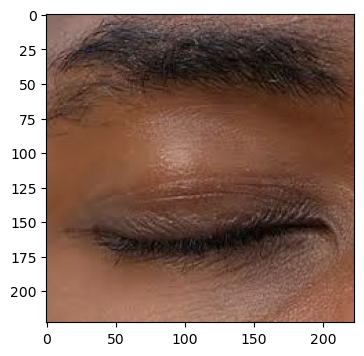

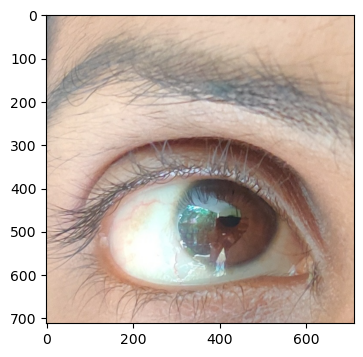

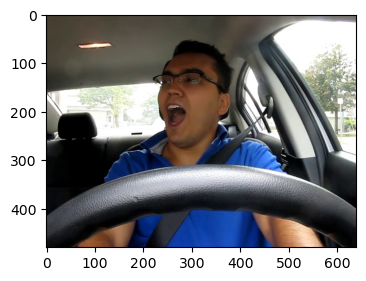

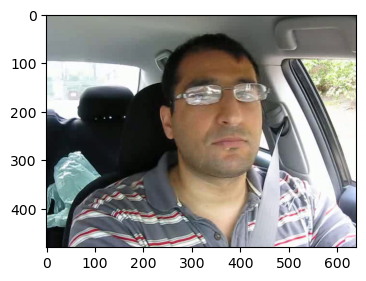

In [8]:


def show_image(image_folder_path):
  for i in range(len(train_classes)):
    s = os.listdir(image_folder_path + '/' + test_classes[i])
    for j in range(len(s)):
      image_path  = image_folder_path + test_classes[i] +'/'+ s[j]
      image=plt.imread(image_path)
      fig=plt.figure(figsize=(4,4))
      plt.imshow(image)
      break
    continue


show_image(data_dir+'/train/')

# **#showing one image for each test class**

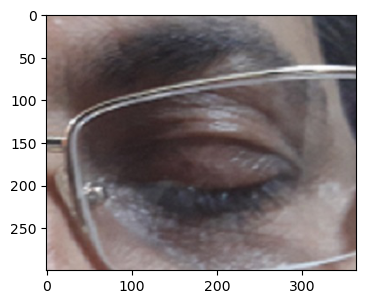

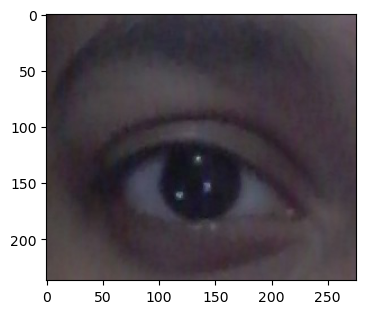

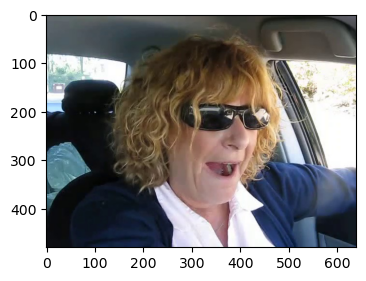

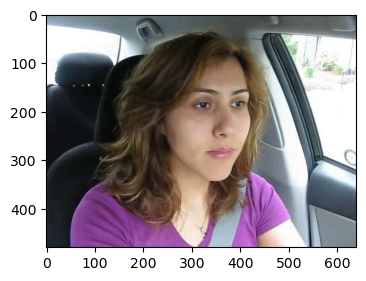

In [9]:

show_image(data_dir+'/test/')

# DATA PREPROCESSING

In [10]:
class CFG:
  batch_size = 16
  size = 256

In [11]:
#function to load images 

def load_images(directory):
    images = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in tqdm(os.listdir(directory+category)):
            image_path = os.path.join(directory,category,filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            images.append(image)
            labels.append(category)
    
    images = np.array(images,dtype='float32')
    return images, labels


#loading dataset
print('*******Loading Train Data*******')
train_ds = load_images(data_dir + '/train/' )
print('*******Loading Test Data*******')
test_ds = load_images(data_dir + '/test/')

*******Loading Train Data*******


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

*******Loading Test Data*******


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

In [13]:
x_train,y_train = train_ds
x_test,y_test =  test_ds

In [14]:
#Normalizing train dataset

layer = layers.Normalization()
layer.adapt(x_train)
x_train = layer(x_train)

#Normalizing test dataset

layer = layers.Normalization()
layer.adapt(x_test)
x_test = layer(x_test)

In [15]:
print(y_train[:10])

['Closed', 'Closed', 'Closed', 'Closed', 'Closed', 'Closed', 'Closed', 'Closed', 'Closed', 'Closed']


In [18]:
#label encoding for y_train and y_test


encoder = LabelEncoder()
y_train_ = encoder.fit_transform(y_train)
ytrain_map = dict(zip(y_train, y_train_))  # get the mapping between the original labels and encoded labels
y_test_ = encoder.transform(y_test)
ytest_map =  dict(zip(y_test, y_test_))  # get the mapping between the original labels and encoded labels
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)

In [19]:
ytrain_map

{'Closed': 0, 'Open': 1, 'yawn': 3, 'no_yawn': 2}

In [20]:
ytest_map

{'Closed': 0, 'Open': 1, 'yawn': 3, 'no_yawn': 2}

# MODEL

In [21]:
## Lets define Drowsiness model 


Drowsiness_detection = tf.keras.models.Sequential([

  layers.Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=(224,224,3)),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same'),
  layers.MaxPooling2D(pool_size=2),
  layers.BatchNormalization(),
  layers.Dropout(0.5),

  layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.BatchNormalization(),
  layers.Dropout(0.2),

  layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.BatchNormalization(),
  layers.Dropout(0.25),

  layers.Flatten(),

  layers.Dense(units=128,activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.25),

  layers.Dense(units=4,activation='softmax')
])

In [22]:
Drowsiness_detection.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 32)       128       
 ormalization)                                                   
                                                        

In [23]:
#defining attributes of Model

Drowsiness_detection.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
early_stopping = EarlyStopping(monitor='test_accuracy',patience=20,mode='max',
                                                        verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='test_accuracy',patience=5,mode='max',verbose=1,factor=0.1,min_lr=0.001)

In [25]:
#saving model and it's parameters


checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,
                    monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

**training the model**

In [27]:

#epochs should be more 20
model = Drowsiness_detection.fit(x=x_train,
            y=y_train,
            epochs=20,
            batch_size=16,
            validation_data=(x_test,y_test),
            callbacks=[early_stopping,reduce_lr,model_checkpoint],
            )

Epoch 1/20
155/155 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.7641
Epoch 1: val_accuracy improved from -inf to 0.25404, saving model to checkpoint/
155/155 [==============================] - 95s 615ms/step - loss: 0.5143 - accuracy: 0.7641 - val_loss: 4.2410 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 2/20
155/155 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8233
Epoch 2: val_accuracy improved from 0.25404 to 0.49192, saving model to checkpoint/
155/155 [==============================] - 91s 590ms/step - loss: 0.4132 - accuracy: 0.8233 - val_loss: 1.4394 - val_accuracy: 0.4919 - lr: 0.0010
Epoch 3/20
155/155 [==============================] - ETA: 0s - loss: 0.3510 - accuracy: 0.8516
Epoch 3: val_accuracy improved from 0.49192 to 0.81293, saving model to checkpoint/
155/155 [==============================] - 93s 602ms/step - loss: 0.3510 - accuracy: 0.8516 - val_loss: 0.4345 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 4/20
155/155 [==

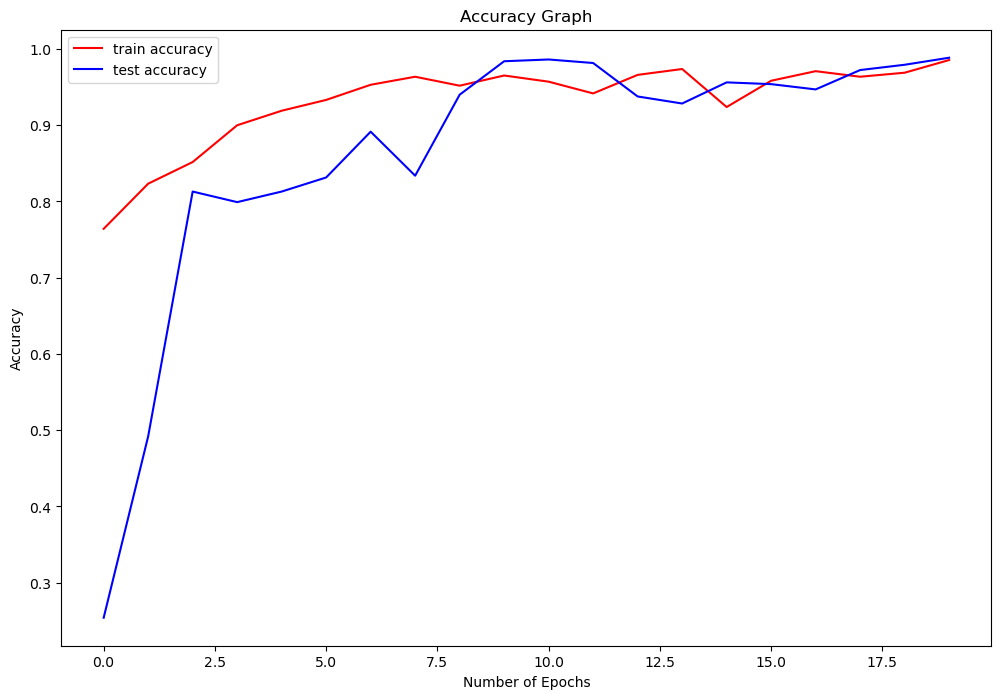

In [29]:
plt.figure(figsize=(12,8))
plt.plot(model.history['accuracy'],'r',label='train accuracy')
plt.plot(model.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

**Save the model**

In [53]:
Drowsiness_detection.save('my_model.h5')

In [54]:
new_model = tf.keras.models.load_model('my_model.h5')

In [55]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 32)       128       
 ormalization)                                                   
                                                        